In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
from tensorflow.python.keras import backend
from tensorflow.python.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive #Dataset mounted from google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/anime_with_synopsis.csv')

In [ ]:
df

,MAL_ID,Name,Score,Genders,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...
...,...,...,...,...,...
16209,48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",No synopsis information has been added to this...
16210,48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",ko is a typical high school student whose life...
16211,48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Sequel to Higurashi no Naku Koro ni Gou .
16212,48491,Yama no Susume: Next Summit,Unknown,"Adventure, Slice of Life, Comedy",New Yama no Susume anime.


In [ ]:
df.Genders.value_counts().head(15) #visualizing top 15 genders

Music                    790
Comedy                   668
Kids                     413
Kids, Music              234
Dementia                 228
Slice of Life            217
Music, Kids              201
Slice of Life, Comedy    171
Fantasy                  153
Drama                    136
Comedy, Kids             130
Comedy, Parody           120
Comedy, Slice of Life    119
Adventure, Fantasy       103
Drama, Kids               95
Name: Genders, dtype: int64

In [ ]:
temp1=df[df["Genders"] == "Music"]
temp2=df[df["Genders"] == "Comedy"]
temp3=df[df["Genders"] == "Fantasy"]
temp4=df[df["Genders"] == "Drama"]
temp5=df[df["Genders"] == "Dementia"]

In [ ]:
merged_df = pd.concat([temp1, temp2, temp3,temp4,temp5]) #merge only 5 genders for better accuracy

In [ ]:
merged_df.Genders.value_counts()

Music       790
Comedy      668
Dementia    228
Fantasy     153
Drama       136
Name: Genders, dtype: int64

In [ ]:
df=merged_df

In [ ]:
df

,MAL_ID,Name,Score,Genders,sypnopsis
1359,1561,Lovedol: Lovely Idol,6.18,Music,"ovedol, or Lovely Idol, is a girl group consis..."
1973,2274,CLAMP in Wonderland,6.86,Music,short video set to music featuring many of CLA...
2321,2728,TWO-MIX: White Reflection,6.76,Music,"music video to Two-Mix's ""White Reflection""; t..."
2464,2938,Idol Densetsu Eriko,6.82,Music,"Eriko Tamura is Kousuke Tamura, the chairman o..."
2870,3685,4-Day Weekend,5.66,Music,usic video for the song Four-Day Weekend by a ...
...,...,...,...,...,...
15590,42281,Zap Cat,Unknown,Dementia,Completed psychedelic anime. As a personal wor...
15621,42354,Fusuma no Oku,Unknown,Dementia,The theme came from the Japanese unique folklo...
15782,42800,Wild Cleaner,Unknown,Dementia,station ID by Densuke28 for MTV ULTRAHITS.
15991,44059,Puparia,7.48,Dementia,Independent short animation by Shingo Tamagawa.


In [ ]:
df=merged_df.reset_index(drop=True) #reset the starting index from 0

In [ ]:
df

,MAL_ID,Name,Score,Genders,sypnopsis
0,1561,Lovedol: Lovely Idol,6.18,Music,"ovedol, or Lovely Idol, is a girl group consis..."
1,2274,CLAMP in Wonderland,6.86,Music,short video set to music featuring many of CLA...
2,2728,TWO-MIX: White Reflection,6.76,Music,"music video to Two-Mix's ""White Reflection""; t..."
3,2938,Idol Densetsu Eriko,6.82,Music,"Eriko Tamura is Kousuke Tamura, the chairman o..."
4,3685,4-Day Weekend,5.66,Music,usic video for the song Four-Day Weekend by a ...
...,...,...,...,...,...
1970,42281,Zap Cat,Unknown,Dementia,Completed psychedelic anime. As a personal wor...
1971,42354,Fusuma no Oku,Unknown,Dementia,The theme came from the Japanese unique folklo...
1972,42800,Wild Cleaner,Unknown,Dementia,station ID by Densuke28 for MTV ULTRAHITS.
1973,44059,Puparia,7.48,Dementia,Independent short animation by Shingo Tamagawa.


In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = df.reset_index(drop=True)
replace_by_space = re.compile('[/(){}\[\]\|@,;]')
bad_symbols = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower() # lowercase text
    text = replace_by_space.sub(' ', text) # replace 'replace_by_space' symbols by space in text and substitute the matched string with space.
    text = bad_symbols.sub('', text) # remove symbols which are in 'bad_symbols' from text and substitute the matched string with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
df['sypnopsis'] = df['sypnopsis'].astype(str).apply(clean_text)
df['sypnopsis'] = df['sypnopsis'].str.replace('\d+', '')

In [ ]:
df

,MAL_ID,Name,Score,Genders,sypnopsis
0,1561,Lovedol: Lovely Idol,6.18,Music,ovedol lovely idol girl group consisting two g...
1,2274,CLAMP in Wonderland,6.86,Music,short video set music featuring many clamps po...
2,2728,TWO-MIX: White Reflection,6.76,Music,music video twomis white reflection group anim...
3,2938,Idol Densetsu Eriko,6.82,Music,eriko tamura kousuke tamura chairman tamura pr...
4,3685,4-Day Weekend,5.66,Music,usic video song fourday weekend british indie ...
...,...,...,...,...,...
1970,42281,Zap Cat,Unknown,Dementia,completed psychedelic anime personal work last...
1971,42354,Fusuma no Oku,Unknown,Dementia,theme came japanese unique folklore red unclea...
1972,42800,Wild Cleaner,Unknown,Dementia,station id densuke mtv ultrahits
1973,44059,Puparia,7.48,Dementia,independent short animation shingo tamagawa


In [ ]:
df['sypnopsis'].astype(str).values

array(['ovedol lovely idol girl group consisting two generations idols rd generation make debut surprise delayed vague reason lack something manager rd gen girls must find answer',
       'short video set music featuring many clamps popular anime manga characters time production accompanying song tells wonderland filled imagination magic dreams source ann',
       'music video twomis white reflection group animated form notices strange light follows various locations',
       ..., 'station id densuke mtv ultrahits',
       'independent short animation shingo tamagawa',
       'tv show unclear broadcast strange room recording editing taking place middleaged gentleman like wa figure sits turntable grabs microphone director signals reading mysterious genre ficfyon begun heck time monologue man sitting audience continuing talk story soon move ficfyon prophecies s source carte blanche'],
      dtype=object)

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(df['sypnopsis'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 10447 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['sypnopsis'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1975, 250)


In [ ]:
X

array([[   0,    0,    0, ...,  222,   99,  640],
       [   0,    0,    0, ...,  151,    4,   25],
       [   0,    0,    0, ...,  113,  120, 4390],
       ...,
       [   0,    0,    0, ..., 1743,  940, 2081],
       [   0,    0,    0, ...,  266,    5,    7],
       [   0,    0,    0, ..., 4384,  642,    4]], dtype=int32)

In [ ]:
Y = pd.get_dummies(df['Genders']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1975, 5)


In [ ]:
Y

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 7)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1777, 250) (1777, 5)
(198, 250) (198, 5)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
25/25 [==============================] - 24s 781ms/step - loss: 1.5336 - accuracy: 0.3733 - val_loss: 1.3468 - val_accuracy: 0.3258
Epoch 2/10
25/25 [==============================] - 19s 745ms/step - loss: 1.2979 - accuracy: 0.4230 - val_loss: 1.1993 - val_accuracy: 0.5618
Epoch 3/10
25/25 [==============================] - 19s 748ms/step - loss: 1.0775 - accuracy: 0.6246 - val_loss: 0.7837 - val_accuracy: 0.6910
Epoch 4/10
25/25 [==============================] - 19s 756ms/step - loss: 0.6771 - accuracy: 0.7788 - val_loss: 0.7506 - val_accuracy: 0.7135
Epoch 5/10
25/25 [==============================] - 19s 752ms/step - loss: 0.5610 - accuracy: 0.8196 - val_loss: 0.7272 - val_accuracy: 0.7416
Epoch 6/10
25/25 [==============================] - 19s 748ms/step - loss: 0.4094 - accuracy: 0.8629 - val_loss: 0.7072 - val_accuracy: 0.7584
Epoch 7/10
25/25 [==============================] - 19s 749ms/step - loss: 0.3315 - accuracy: 0.8792 - val_loss: 0.6722 - val_accuracy: 0.7640

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/15
50/50 [==============================] - 32s 573ms/step - loss: 1.4576 - accuracy: 0.3743 - val_loss: 1.1959 - val_accuracy: 0.5056
Epoch 2/15
50/50 [==============================] - 30s 592ms/step - loss: 1.0715 - accuracy: 0.6349 - val_loss: 0.8067 - val_accuracy: 0.6854
Epoch 3/15
50/50 [==============================] - 28s 557ms/step - loss: 0.7004 - accuracy: 0.7495 - val_loss: 0.6922 - val_accuracy: 0.7528
Epoch 4/15
50/50 [==============================] - 28s 557ms/step - loss: 0.5155 - accuracy: 0.8288 - val_loss: 0.6740 - val_accuracy: 0.7809
Epoch 5/15
50/50 [==============================] - 28s 555ms/step - loss: 0.3952 - accuracy: 0.8655 - val_loss: 0.6696 - val_accuracy: 0.7528
Epoch 6/15
50/50 [==============================] - 28s 556ms/step - loss: 0.3260 - accuracy: 0.8841 - val_loss: 0.6798 - val_accuracy: 0.7640
Epoch 7/15
50/50 [==============================] - 28s 555ms/step - loss: 0.2498 - accuracy: 0.9076 - val_loss: 0.7603 - val_accuracy: 0.7753

In [ ]:
new_summary  = ['Completed some assignments , feels really productive today']
seq = tokenizer.texts_to_sequences(new_summary )
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Music', 'Comedy', 'Fantasy', 'Drama', 'Dementia']
print(pred, labels[np.argmax(pred)])


[[0.45248693 0.04583023 0.0287943  0.03456169 0.4383269 ]] Music


In [ ]:
pred_val = labels[np.argmax(pred)]
print(pred_val)

Music


In [ ]:
recommend =df[df["Genders"] == pred_val].head(5)

In [ ]:
recommend["Name"] #recommended animes 

0         Lovedol: Lovely Idol
1          CLAMP in Wonderland
2    TWO-MIX: White Reflection
3          Idol Densetsu Eriko
4                4-Day Weekend
Name: Name, dtype: object

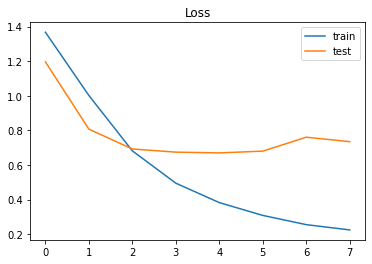

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

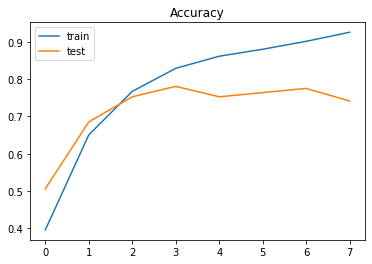

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()